# SREBP2 Cholesterol GNN Explanations


First, we start by installing all of the approporiate packages:

In [7]:
%pip install torch_geometric # install pytorch geometric
%pip install torchvision #install torchvision
%pip install matplotlib #install matplotlib

%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.explain import GNNExplainer,Explainer,GraphMaskExplainer,PGExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv
from torch.nn import Linear,Softmax
import os
from tqdm import tqdm, trange
import pickle

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## GNN Architecture

Here we are setting up the graph neural network architecture to be used with this data set. This is a network with 4 graph layers and 2 linear layers.

In [8]:
class SimpleGAT_1(torch.nn.Module):
    """
    A graph attention network with 4 graph layers and 2 linear layers.
    Uses v2 of graph attention that provides dynamic instead of static attention.
    The graph layer dimension and number of attention heads can be specified.
    """
    #torch.device('mps')
    def __init__(self, dataset, dim=8, num_heads=4):
        super(SimpleGAT_1, self).__init__()
        torch.manual_seed(seed=123)
        self.conv1 = GATv2Conv(in_channels=dataset.num_features, out_channels=dim, heads=num_heads,edge_dim=dataset.edge_attr.shape[1])
        self.conv2 = GATv2Conv(in_channels=dim * num_heads, out_channels=dim, heads=num_heads,edge_dim=dataset.edge_attr.shape[1])
        self.lin1 = Linear(dim * num_heads,dim)
        self.lin2 = Linear(dim,1)

    def forward(self, x, edge_index,edge_attr):
        h = self.conv1(x, edge_index,edge_attr).relu()
        h = self.conv2(h, edge_index,edge_attr).relu()
        h = self.lin1(h).relu()
        #print(h)
        h = F.dropout(h, p=0.1, training=self.training)
        out = self.lin2(h)[:,0]
        out = torch.sigmoid(out)
        return out

## Load In Data

Here we are connecting colab to my personal google drive in order to access the data needed for this project.

Once we load in the data and path for the model, we fit the model using the simple GAT 1 class we made above.

In [9]:
data = torch.load('SREBP2_0.pt')
model_path = 'SimpleGAT_1_model_lr_0.0001_dp_0.7.pth'
model = SimpleGAT_1(data,dim = 16)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.eval()

SimpleGAT_1(
  (conv1): GATv2Conv(165, 16, heads=4)
  (conv2): GATv2Conv(64, 16, heads=4)
  (lin1): Linear(in_features=64, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

In [10]:
# Use data to get feature labels and remove all elements of data that are not a feature label

feat_labels = list(data.to_dict().keys())
to_remove = ['edge_index', 
 'experimental',
 'database',
 'textmining',
 'combined_score',
 'binary_experimental',
 'binary_database',
 'binary_textmining',
 'num_nodes',
 'x',
 'y',
 'edge_attr',
 'num_classes',
 'label']

for element in to_remove:
    feat_labels.remove(element)

## NPC1 Node

We are starting by looking at the NPC1 Node. The NPC1 gene is known to have involvement in the cholesterol homeostasis process. This gene mediates intracellular cholesterol trafficking via binding of cholesterol to its N-terminal domain. Defects in this gene are known to cause disorders that are due to the over accumulation of cholesterol and glycosphingolipids.

For more information on the NPC1 gene, see this link: https://medlineplus.gov/genetics/gene/npc1/

In [11]:
NPC1_node = '9606.ENSP00000269228'
with open('node_order.pickle', 'rb') as f:
    node_order = pickle.load(f)
    
node_index = node_order[NPC1_node]

### GNN Explainer

First, we will be starting with GNN Explainer. These settings are the default settings of gnn explainer. 

In [12]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

In [13]:
explanation = explainer(data.x, data.edge_index, index=node_index,edge_attr = data.edge_attr)

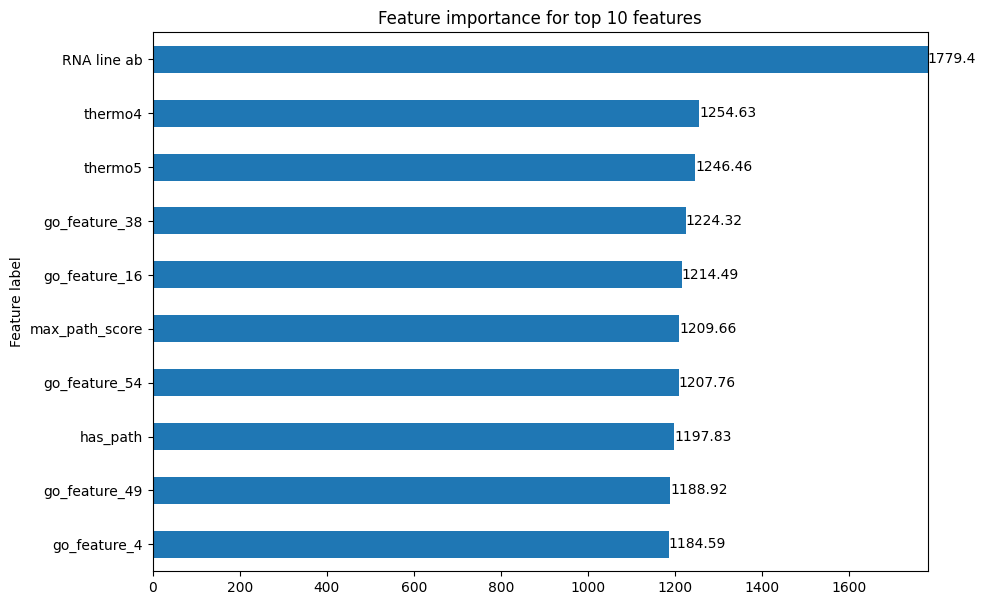

In [14]:
explanation.visualize_feature_importance(top_k=10, feat_labels=feat_labels)

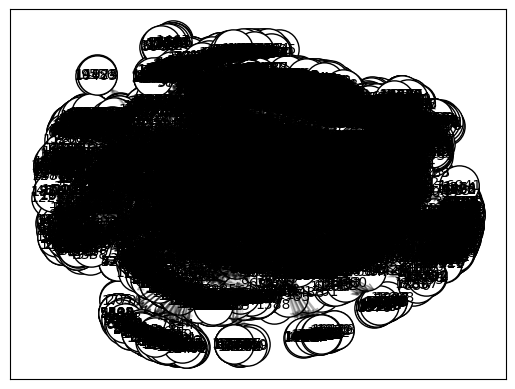

In [15]:
explanation.visualize_graph()

In [16]:
from torch_geometric.explain.metric import fidelity

fid_pm = fidelity(explainer, explanation)
print(fid_pm)
#(positive fidelity, negative fidelity)

(1.0, 0.0)


In [17]:
from torch_geometric.explain import unfaithfulness

unfaithful_metric = unfaithfulness(explainer, explanation)
print(unfaithful_metric)

0.10797226428985596


## PG Explainer

Next, we will try to use PG Explainer on the NPC1 Node:

In [18]:
from torch_geometric.explain import PGExplainer, ModelConfig

pg_explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

# Train against a variety of node-level or graph-level predictions:
for epoch in range(30): # Indices to train against.
        loss = pg_explainer.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=node_index, edge_attr = data.edge_attr)
# Get the final explanations:
pg_explanation = pg_explainer(data.x, data.edge_index, target=data.y, index=node_index, edge_attr = data.edge_attr)

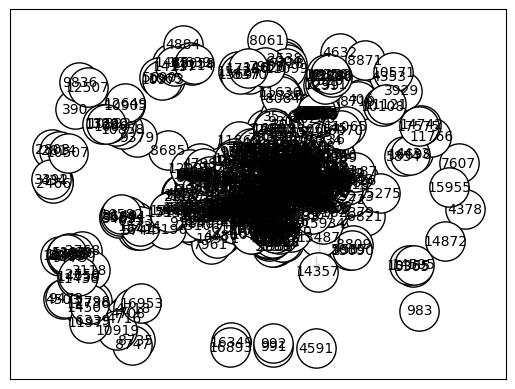

In [19]:
pg_explanation.visualize_graph()

In [23]:
fid_pg = fidelity(pg_explainer, pg_explanation)
print(fid_pg)
#(positive fidelity, negative fidelity)

(0.0, 0.0)


## Graph Mask

Next, we will use GraphMask for an explanation on the NPC1 Node:

In [20]:
from torch_geometric.explain import GraphMaskExplainer


gm_explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)

gm_explanation = gm_explainer(data.x, data.edge_index, index=node_index, edge_attr=data.edge_attr)

Train explainer for node(s) tensor([6179]) with layer 1: 100%|██████████| 5/5 [01:31<00:00, 18.35s/it]
Train explainer for node(s) tensor([6179]) with layer 0: 100%|██████████| 5/5 [04:24<00:00, 52.89s/it]
Explain: 100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


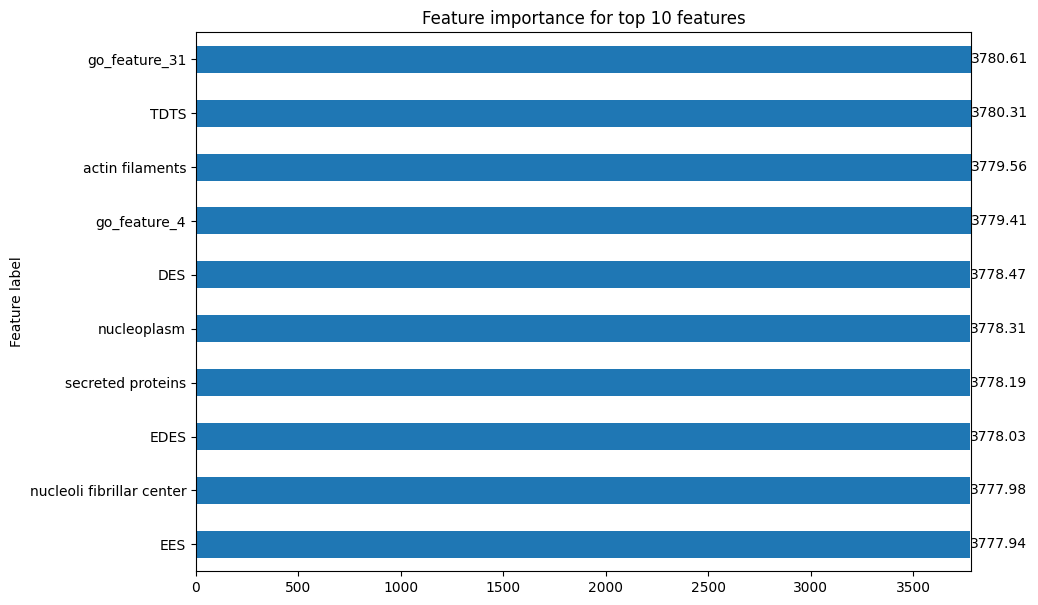

In [21]:
gm_explanation.visualize_feature_importance(top_k=10, feat_labels=feat_labels)

In [22]:
# gm_explanation.visualize_graph()

In [24]:
fid_gm = fidelity(gm_explainer, gm_explanation)
print(fid_gm)
#(positive fidelity, negative fidelity)

(1.0, 1.0)
